In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

In [3]:
## Reading in File
data = pd.read_csv('political_demographics.csv')
print(data.shape)
data.head()

(1850, 37)


,General_2016-11-08,Runoff_2016-05-24,Primary_2016-03-01,Runoff_2015-12-12,General_2014-11-04,Runoff_2014-08-05,Runoff_2014-05-27,Primary_2014-03-04,Runoff_2013-12-14,Runoff_2013-03-02,...,PoliticalContributerInHome,DonatesEnvironmentCauseInHome,DonatesToCharityInHome,Donates to Local Community,State_Senate_District,Local_Municipal_Sum,Times_Voted,Parties_Description,GetOut,preference
0,Y,N,N,N,Y,N,N,N,N,N,...,0,Unknown,Yes,Yes,s13,0,4,Democratic,N,Y
1,Y,Y,Y,Y,Y,N,N,N,N,N,...,0,Unknown,Yes,Unknown,s13,0,6,Democratic,Y,N
2,Y,Y,Y,Y,Y,N,Y,Y,N,N,...,0,Unknown,Unknown,Unknown,s13,2,14,Democratic,N,N
3,Y,N,Y,N,Y,N,N,N,N,N,...,0,Unknown,Unknown,Unknown,s13,0,5,Democratic,N,N
4,Y,N,N,Y,Y,N,N,Y,N,N,...,0,Unknown,Unknown,Unknown,s13,0,6,Democratic,N,Y


# Two sets of binary prediction, voter turnout (GetOut) and voter preference towards a certain issue (preference) 

In [27]:
## Proportion of classes
1. * data['GetOut'].value_counts() / len(data['GetOut'])

N    0.75027
Y    0.24973
Name: GetOut, dtype: float64

In [ ]:
1. * data['preference'].value_counts() / len(houston['preference'])

In [36]:
## Transforming all categorical data into binary counts
data = pd.get_dummies(data.loc[:,'General_2016-11-08':])

data.shape

(1850, 103)

In [37]:
## Creating training and test data for turnout and preference

features = data.loc[:,'Voters_Age':'Parties_Description_Republican']

## Voter Turnout (GetOut)
X_go = features.values
y_go = data['GetOut_Y'].values
## Splitting data into 90 - 10 split for taining and testing
X_train_go, X_test_go, y_train_go, y_test_go = train_test_split(X_go,y_go, test_size = 0.1, random_state = 12)

## Voter Preference (preference)
X_pre = features.values
y_pre = data['preference_Y'].values
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_pre,y_pre, test_size = 0.1, random_state = 12)

# Supervised Learning 
## Voter Turnout

In [26]:
## Grid Search over parameters
## Each set of models were 10 fold cross validated
## Tuning across several grid values
## Best model was chosen with the highest AUC score

## Logistic Regression
## Grid values for ridge or lasso regularization 
param_grid_lr = {'C' : [0.001,0.01,0.1,1,10,100],
                 'penalty':['l1','l2']}

grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv = 10, n_jobs = 3,scoring = 'roc_auc')

grid_search_lr.fit(X_train_go, y_train_go)

grid_search_lr.score(X_test_go, y_test_go)

0.57321375335387059

In [27]:
## Confusion Matrix
predicted_logreg = grid_search_lr.predict(X_test_go)
confusion_matrix(y_test_go,predicted_logreg)

array([[346,   1],
       [113,   3]])

In [28]:
## Best set of parameters
grid_search_lr.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [48]:
## Random Forest

param_grid_rf = {'max_features' : [4, 'sqrt', 'log2'],
             'n_estimators': [500,1000, 1500, 2000]}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv = 10, n_jobs = 3, scoring= 'roc_auc')

grid_search_rf.fit(X_train_go, y_train_go)

grid_search_rf.score(X_test_go, y_test_go)

0.58056742522110705

In [49]:
## Confusion Matrix
predicted_rf = grid_search_rf.predict(X_test_go)
confusion_matrix(y_test_go,predicted_rf)

array([[335,  12],
       [111,   5]])

In [50]:
## Best parameters
grid_search_rf.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

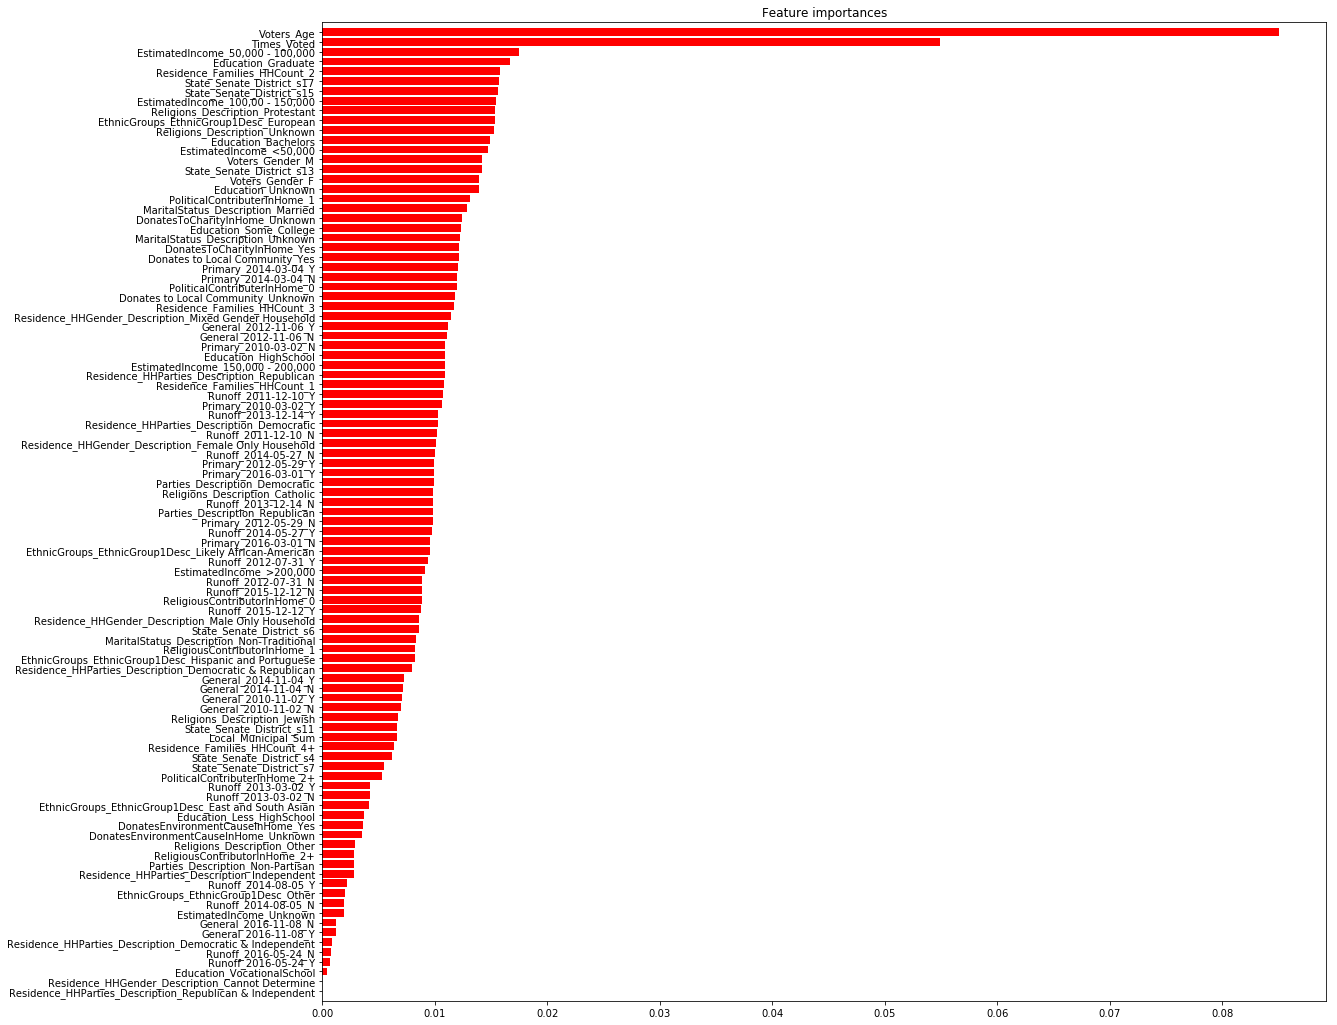

In [51]:
## Plotting Feature importance

## Fitting object with optimal paramteres
forest = RandomForestClassifier(n_estimators = 1000, max_features='sqrt')
forest.fit(X_train_go,y_train_go)

import matplotlib.pyplot as plt
%matplotlib inline
importances = forest.feature_importances_
indices = np.argsort(importances)
feature_names = features_go.columns 

plt.figure()
f, ax = plt.subplots(figsize=(18, 18))
plt.title("Feature importances")
plt.barh(range(X_train_go.shape[1]), importances[indices],
       color="r",align="center")

plt.yticks(range(X_train_go.shape[1]), feature_names[indices])
plt.ylim([-1, X_train_go.shape[1]])
plt.show()


In [39]:
## XGBoost implementation
param_grid_xgb = {'learning_rate' : [0.1,0.3, 0.05, 0.75],
             'n_estimators': [50, 100, 200, 300],
                 'max_depth': [3,5]}

grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv = 10, n_jobs=-1,scoring= 'roc_auc')

grid_search_xgb.fit(X_train_go, y_train_go)

grid_search_xgb.score(X_test_go, y_test_go)

0.67155172413793107

In [40]:
## Confusion Matrix
predicted_xgb = grid_search_xgb.predict(X_test_go)
confusion_matrix(y_test_go,predicted_xgb)

array([[143,   2],
       [ 38,   2]])

In [41]:
## Best Parameters
grid_search_xgb.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

## Vote Preference

In [38]:
## Logistic Regression
param_grid_lr = {'C' : [0.001,0.01,0.1,1,10,100],
                 'penalty':['l1','l2']}

grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv = 10, n_jobs = 3, scoring = 'roc_auc')

grid_search_lr.fit(X_train_pre, y_train_pre)

grid_search_lr.score(X_test_pre, y_test_pre)

0.52342460615153796

In [39]:
## Confusion Matrix
predicted_logreg = grid_search_lr.predict(X_test_pre)
confusion_matrix(y_test_pre,predicted_logreg)

array([[ 67, 148],
       [ 67, 181]])

In [40]:
## Best Parameters
grid_search_lr.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [41]:
## Random Forest
param_grid_rf = {'max_features' : [4, 'sqrt', 'log2'],
             'n_estimators': [500,1000, 1200, 1500, 2000]}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv = 10, n_jobs = 3, scoring= 'roc_auc')

grid_search_rf.fit(X_train_pre, y_train_pre)

grid_search_rf.score(X_test_pre, y_test_pre)

0.57246811702925726

In [42]:
## Confusion Matrix
predicted_rf = grid_search_rf.predict(X_test_pre)
confusion_matrix(y_test_pre,predicted_rf)

array([[ 83, 132],
       [ 71, 177]])

In [43]:
## Best Parameters
grid_search_rf.best_params_

{'max_features': 'log2', 'n_estimators': 1000}

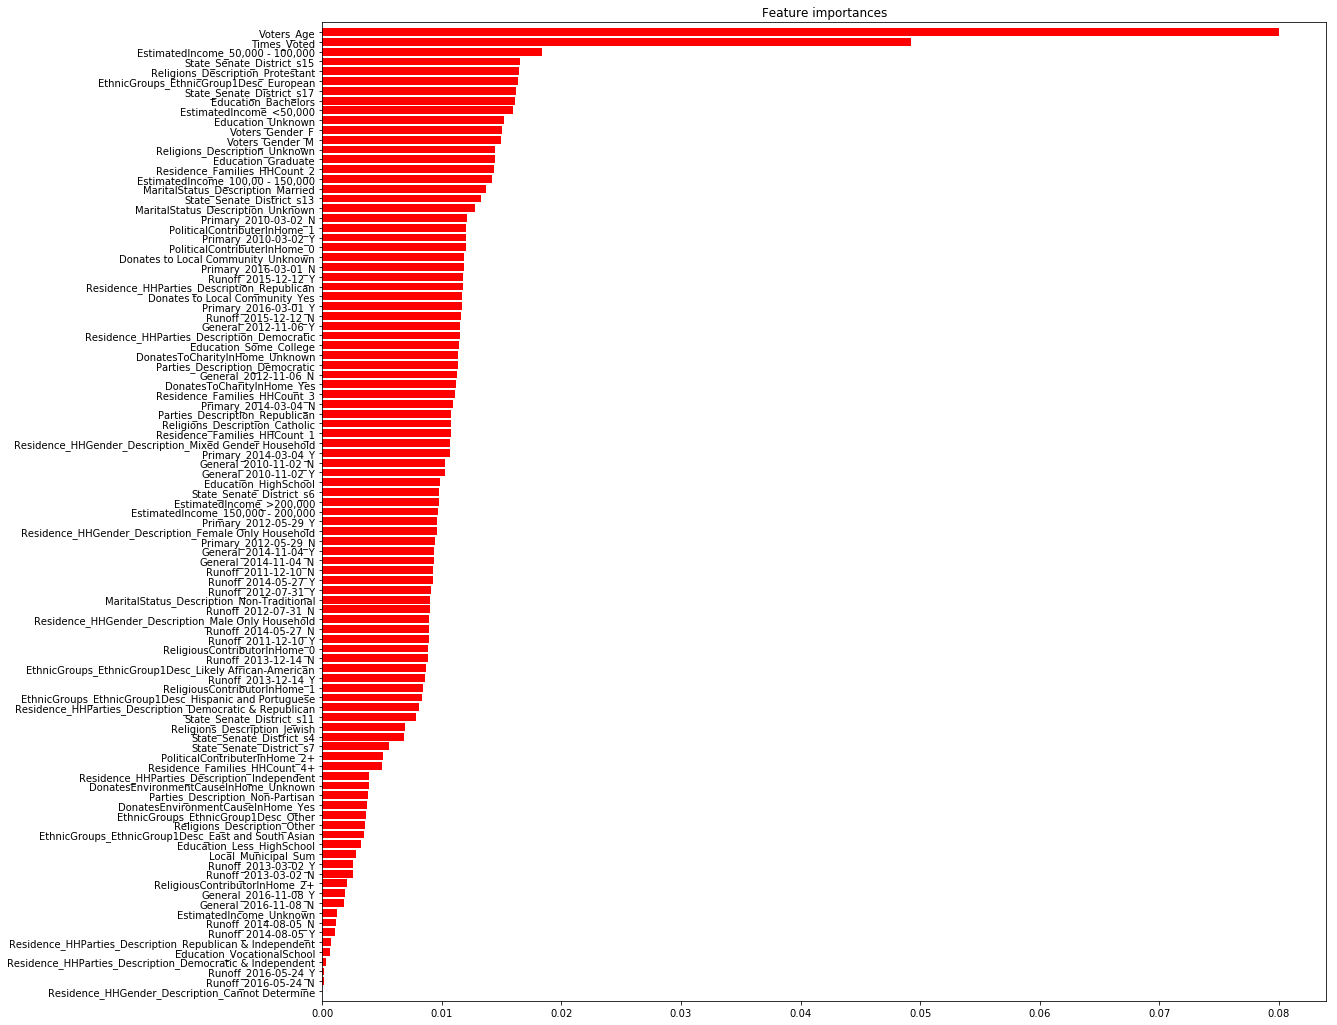

In [52]:
## Plotting feature importance
forest = RandomForestClassifier(n_estimators = 1000, max_features='log2')
forest.fit(X_train_preference,y_train_preference)

import matplotlib.pyplot as plt
%matplotlib inline
importances = forest.feature_importances_
indices = np.argsort(importances)
feature_names = features_preference.columns 

plt.figure()
f, ax = plt.subplots(figsize=(18, 18))
plt.title("Feature importances")
plt.barh(range(X_train_preference.shape[1]), importances[indices],
       color="r",align="center")

plt.yticks(range(X_train_pre.shape[1]), feature_names[indices])
plt.ylim([-1, X_train_pre.shape[1]])
plt.show()

In [44]:
### XGBoost implementation

param_grid_xgb = {'learning_rate' : [0.1,0.3, 0.05, 0.75],
             'n_estimators': [50, 100, 200, 300],
                 'max_depth': [3,5]}

grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv = 10, n_jobs=3,scoring= 'roc_auc')

start = time.time()
grid_search_xgb.fit(X_train_pre, y_train_pre)
print(time.time() - start)
grid_search_xgb.score(X_test_pre, y_test_pre)

72.68635511398315


0.52528132033008246

In [45]:
## Confusion Matrix
predicted_xgb = grid_search_xgb.predict(X_test_pre)
confusion_matrix(y_test_pre,predicted_xgb)

array([[ 96, 119],
       [102, 146]])

In [46]:
## Best Parameters
grid_search_xgb.best_params_

{'learning_rate': 0.75, 'max_depth': 5, 'n_estimators': 300}